## **Tensorflow Implementation for the paper: Deep convolutional bidirectional LSTM recurrent neural network for epileptic seizure detection**

In [1]:
import warnings
import os
import random
import numpy as np

# Suppress warnings first
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# Set seed
SEED = 42

# Reproducibility environment variables (MUST be before TensorFlow import)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Set all random seeds
random.seed(SEED)
np.random.seed(SEED)

# Now import TensorFlow and other libraries
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, BatchNormalization, LSTM, Bidirectional, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# TensorFlow reproducibility settings
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()
tf.keras.utils.set_random_seed(SEED)

# GPU configuration for reproducibility
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-07-25 15:47:19.283319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753476439.297101 1408366 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753476439.301270 1408366 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Create models directory
import os
os.makedirs('models', exist_ok=True)
os.makedirs('models/weights', exist_ok=True)
os.makedirs('models/full_models', exist_ok=True)

In [3]:
# Parameters
DATAPATH = "./data"  # UPDATE THIS PATH!
NUMBER_OF_SAMPLES = 200
ORIGINAL_SEQUENCE_SIZE = 4097
NUM_EPOCHS = 20
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.2
N_SPLITS = 10

# Model parameters
CONV_FILTERS = 16
CONV_KERNEL_SIZE = 5
POOL_SIZE = 3
LSTM_UNITS = 20
LSTM_DROPOUT = 0.1
BATCH_NORM_MOMENTUM = 0.9

In [4]:
# Data loading functions
def read_eeg_files(data_path, file_identifier):
    data_list = []
    for filename in sorted(os.listdir(data_path)):
        if not os.path.isfile(os.path.join(data_path, filename)):
            continue
        if "py" in filename:
            continue
        if file_identifier in filename:
            filepath = os.path.join(data_path, filename)
            with open(filepath, 'r') as f:
                content = f.readlines()
                data_list.extend([float(line.strip()) for line in content if line.strip()])
    return data_list

In [5]:
def load_and_preprocess_data(data_path, num_samples, sequence_size):
    print("Loading EEG data...")
    data_list = []
    data_list.extend(read_eeg_files(data_path, 'O'))  # Normal signals
    data_list.extend(read_eeg_files(data_path, 'S'))  # Seizure signals
    
    X = np.array(data_list).reshape(num_samples, sequence_size)
    y = np.zeros(num_samples)
    y[:num_samples//2] = 1  # Normal (Z) has label 1
    y[num_samples//2:] = 0  # Seizure (S) has label 0
    
    print(f"Data shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Normal samples: {np.sum(y == 1)}, Seizure samples: {np.sum(y == 0)}")
    return X, y

In [6]:
def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape), 
        Conv1D(CONV_FILTERS, CONV_KERNEL_SIZE, activation='relu'),
        BatchNormalization(momentum=BATCH_NORM_MOMENTUM),
        MaxPooling1D(POOL_SIZE),
        Conv1D(CONV_FILTERS, CONV_KERNEL_SIZE, activation='relu'),
        BatchNormalization(momentum=BATCH_NORM_MOMENTUM),
        MaxPooling1D(POOL_SIZE),
        Conv1D(CONV_FILTERS, CONV_KERNEL_SIZE, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(POOL_SIZE),
        Conv1D(CONV_FILTERS, CONV_KERNEL_SIZE, activation='relu'),
        Bidirectional(LSTM(LSTM_UNITS, dropout=LSTM_DROPOUT)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    return model

In [7]:
# Load and preprocess data
X, y = load_and_preprocess_data(DATAPATH, NUMBER_OF_SAMPLES, ORIGINAL_SEQUENCE_SIZE)
X = stats.zscore(X, ddof=0)  # Z-score normalization
print("Data preprocessing completed.")
print(f"Final data shape: {X.shape}")

Loading EEG data...
Data shape: (200, 4097)
Labels shape: (200,)
Normal samples: 100, Seizure samples: 100
Data preprocessing completed.
Final data shape: (200, 4097)


In [ ]:
# Cross-validation
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
cv_scores = []
cm_final = np.zeros((2, 2))

print(f"Starting {N_SPLITS}-fold cross-validation...")

for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    print(f"\nFOLD {fold_idx + 1}/{N_SPLITS}")
    print("=" * 30)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X[train_idx], y[train_idx], 
        test_size=VALIDATION_SPLIT, 
        random_state=SEED,
        stratify=y[train_idx]
    )
    
    # Reshape for CNN
    X_train = np.expand_dims(X_train, axis=2)
    X_val = np.expand_dims(X_val, axis=2)
    X_test = np.expand_dims(X[test_idx], axis=2)
    
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    
    # Create model
    model = create_model(input_shape=(X.shape[1], 1))
    
    if fold_idx == 0:
        print("\nModel Architecture:")
        model.summary()

    filepath = f"models/weights/fold_{fold_idx}_weights.weights.h5"
    
    # Train
    print(f"\nTraining fold {fold_idx + 1}...")
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                       epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=1)
    
    # Evaluate
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    accuracy = accuracy_score(y[test_idx], y_pred)
    cm = confusion_matrix(y[test_idx], y_pred)
    
    cv_scores.append(accuracy * 100)
    cm_final += cm
    
    print(f"\nFold {fold_idx + 1} Results:")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Confusion Matrix:\n{cm}")
    
    # Clean up
    del model
    tf.keras.backend.clear_session()

In [ ]:
# Save the best performing model
print("\nSaving final models...")
# Create and train final model on all data for deployment
print("Training final model on complete dataset...")
X_final = np.expand_dims(X, axis=2)

# Create final model
final_model = create_model(input_shape=(X.shape[1], 1))

# Train on full dataset (for deployment use)
history_final = final_model.fit(
    X_final, y, 
    epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)
# Save complete model (architecture + weights)
final_model.save('models/full_models/seizure_detection_model.h5')
print("✅ Complete model saved: models/full_models/seizure_detection_model.h5")

# Save model weights only
final_model.save_weights('models/weights/final_model_weights.weights.h5')
print("✅ Model weights saved: models/weights/final_model_weights.weights.h5")

# Save model architecture as JSON
model_json = final_model.to_json()
with open('models/seizure_detection_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("✅ Model architecture saved: models/seizure_detection_architecture.json")

# Save training history
import pickle
with open('models/training_history.pkl', 'wb') as f:
    pickle.dump({
        'history': history_final.history,
        'cv_scores': cv_scores,
        'cv_mean': np.mean(cv_scores),
        'cv_std': np.std(cv_scores),
        'confusion_matrix': cm_final.tolist()
    }, f)
print("✅ Training history saved: models/training_history.pkl")

print(f"\n📁 All models saved in 'models/' directory")
print(f"🎯 Cross-validation accuracy: {np.mean(cv_scores):.2f}% (±{np.std(cv_scores):.2f}%)")


Saving final models...

CROSS-VALIDATION SUMMARY

Final Confusion Matrix (sum across all folds):
[[ 98.   2.]
 [  0. 100.]]

Per-fold accuracies:
Fold 1: 100.00%
Fold 2: 100.00%
Fold 3: 100.00%
Fold 4: 95.00%
Fold 5: 100.00%
Fold 6: 100.00%
Fold 7: 100.00%
Fold 8: 95.00%
Fold 9: 100.00%
Fold 10: 100.00%

Overall Performance:
Average Accuracy: 99.00% (±2.00%)
Best Fold: 100.00%
Worst Fold: 95.00%

Detailed Metrics:
Sensitivity: 1.0000
Specificity: 0.9800
Precision: 0.9804
NPV: 1.0000


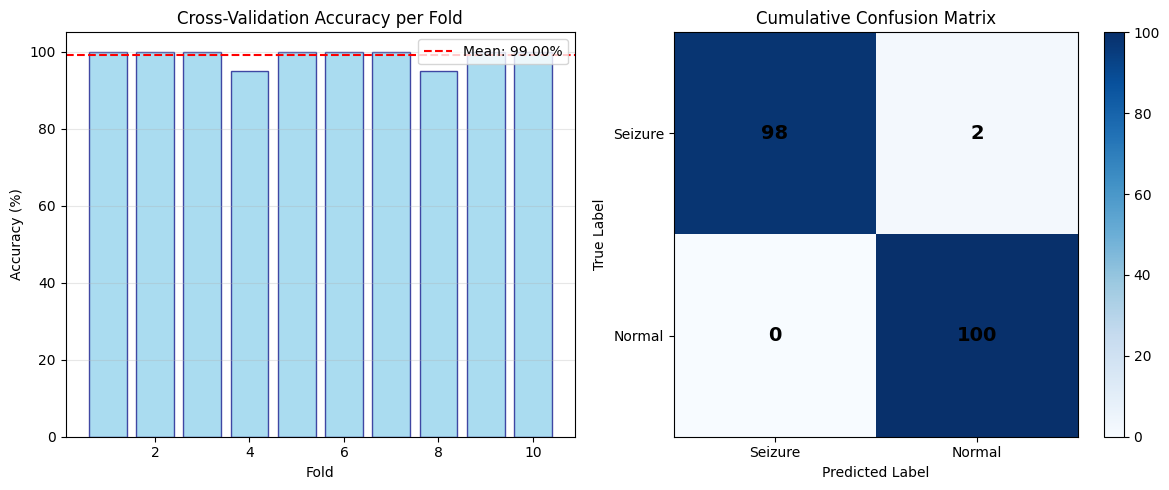


Training completed successfully!


In [10]:
# Save the best performing model
print("\nSaving final models...")

# Final results
print("\n" + "="*50)
print("CROSS-VALIDATION SUMMARY")
print("="*50)

print(f"\nFinal Confusion Matrix (sum across all folds):")
print(cm_final)

print(f"\nPer-fold accuracies:")
for i, score in enumerate(cv_scores):
    print(f"Fold {i+1}: {score:.2f}%")

print(f"\nOverall Performance:")
print(f"Average Accuracy: {np.mean(cv_scores):.2f}% (±{np.std(cv_scores):.2f}%)")
print(f"Best Fold: {np.max(cv_scores):.2f}%")
print(f"Worst Fold: {np.min(cv_scores):.2f}%")

# Additional metrics
tn, fp, fn, tp = cm_final.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
npv = tn / (tn + fn)

print(f"\nDetailed Metrics:")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"NPV: {npv:.4f}")

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, N_SPLITS + 1), cv_scores, alpha=0.7, color='skyblue', edgecolor='navy')
plt.axhline(y=np.mean(cv_scores), color='red', linestyle='--', label=f'Mean: {np.mean(cv_scores):.2f}%')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title('Cross-Validation Accuracy per Fold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.imshow(cm_final, interpolation='nearest', cmap='Blues')
plt.title('Cumulative Confusion Matrix')
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(j, i, int(cm_final[i, j]), ha='center', va='center', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks([0, 1], ['Seizure', 'Normal'])
plt.yticks([0, 1], ['Seizure', 'Normal'])

plt.tight_layout()
plt.show()

print("\nTraining completed successfully!")